In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
import random
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(device)

cuda:1


In [23]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = RobertaTokenizer.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier')
model = RobertaForSequenceClassification.from_pretrained('SkolkovoInstitute/roberta_toxicity_classifier').to(device)

Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Hyperparameters

In [5]:
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$
LEN = len(data)
N_TOKENS = len(tokenizer)
inj_len = 7
#$#$#$#$#$#$#$#$#$#$#$#$#$#$#$

In [6]:
len(tokenizer)

50265

## Vocabulary filtering (short words)

In [8]:
N_TOKENS = len(tokenizer_bert)#len(tokenizer_bert)
TOKENS = list(range(N_TOKENS))
WORDS = [tokenizer_bert.decode(tok) for tok in TOKENS]
print(len(WORDS))
SHORT_WORDS = [w for w in WORDS if len(w) < 4]
print(len(SHORT_WORDS))
TOKENS = [tokenizer_bert.encode(w, add_special_tokens=False) for w in SHORT_WORDS]
TOKENS = [tok[0] for tok in TOKENS if len(tok) == 1]
print(len(TOKENS))
N_TOKENS = len(TOKENS)
vocab = {i:token for i, token in enumerate(TOKENS)}

30522
3848
2850


## Policy Model 

In [9]:
#model
class  Actor(nn.Module):
    def __init__(self, n_tokens=N_TOKENS, hid_size=256, input_emb_size=128, inj_len=inj_len):
        super(self.__class__, self).__init__()
        self.input_layers = nn.Sequential(
            nn.Linear(input_emb_size,hid_size),
            nn.LeakyReLU(),
            nn.Linear(hid_size,512))
        self.output_layers = [nn.Linear(512, n_tokens).to(device) for _ in range(inj_len)]
        
    def forward(self, input_emb, t=5):
        y = nn.LeakyReLU()(self.input_layers(input_emb))
        logits_list = [layer(y) for layer in self.output_layers]
        tokens = []
        if t > 0:
            for logits in logits_list:
                probs = logits.softmax(1).squeeze().detach().cpu().numpy()
                probs = probs ** (1 / t)
                probs = probs / np.sum(probs)
                token = np.random.choice(range(N_TOKENS), p=probs) 
                tokens.append(token)
        if t <= 0:
            for logits in logits_list:
                probs = logits.softmax(1).squeeze().detach().cpu().numpy()
                token = np.argmax(probs)
                tokens.append(token)
            
        return logits_list, tokens
        

## Training

In [11]:
actor = Actor().to(device)
opt_actor = torch.optim.Adam(actor.parameters(),lr=1e-3, betas=(0.9, 0.999))
losses_actor = []

In [12]:
N_ITERS = 500000
skip = 128
inj_best = None
scores_adv = []
scores_adv_max = []
scores_adv_batch = []
rewards = []
MIN_COS = 10
score_adv_ = 1.0
loss = 0

texts = ["This film is a piece of bullshit and I hate it"]
X = tokenizer(texts, truncation=True, padding="longest", max_length=32, add_special_tokens=True)["input_ids"]
emb_init = torch.randn(1,128).to(device)

In [ ]:



for iters in range(N_ITERS):
    
    #actor step
    logits_list, injection = actor(emb_init,t=5)
    
    injection_translated = [vocab[token] for token in injection]
    injection_translated = tokenizer_bert.decode(injection_translated).replace(" ", "")
    injection_translated = tokenizer(injection_translated, add_special_tokens=False)["input_ids"]
    
    #inserting injection
    X_new = []
    for X_i in X:
        X_new_i = X_i[0:1] + injection_translated + X_i[1:]
        X_new.append(X_new_i)
    X_new = torch.tensor(X_new).to(device)
    
    with torch.no_grad():
        score_adv = (model(torch.tensor(X_new).to(device))[0][0][1] - model(torch.tensor(X_new).to(device))[0][0][0]).item()
    scores_adv.append(score_adv)
    
    
    reward = score_adv_ - score_adv
    rewards.append(reward)
    scores_adv_batch.append(score_adv)
    for i, logits in enumerate(logits_list):
        loss += (reward * nn.CrossEntropyLoss(label_smoothing=0.5)(logits,torch.tensor(injection[i])[None].to(device)) / (skip * len(logits_list)))
    if iters % skip == 0: 
        loss.backward()
        opt_actor.step()
        opt_actor.zero_grad()
        losses_actor.append(loss.item())
        loss = 0
        score_adv_ = np.mean(scores_adv_batch)
        scores_adv_batch = []
    
    
    
    with torch.no_grad():
        _, injection_max = actor(emb_init,t=0)
        injection_translated_max = [vocab[token] for token in injection_max]
        injection_translated_max = tokenizer_bert.decode(injection_translated_max).replace(" ", "")
        injection_translated_max = tokenizer(injection_translated_max, add_special_tokens=False)["input_ids"]
        X_new = []
        for X_i in X:
            X_new_i = [X_i[0]] + injection_translated_max + X_i[1:]
            X_new.append(X_new_i)
        X_new = torch.tensor(X_new).to(device)
        score_adv_max = (model(torch.tensor(X_new).to(device))[0][0][1] - model(torch.tensor(X_new).to(device))[0][0][0]).item()
        scores_adv_max.append(score_adv_max)
    
    
    #actor update
    if score_adv_max < MIN_COS:
        MIN_COS = score_adv_
        inj_best = injection_translated_max

    if iters % 128 == 0:
        clear_output(True)
        plt.plot(scores_adv)
        plt.plot(scores_adv_max)
        plt.grid()
        plt.legend(["scores_adv", "scores_adv_max"])
        plt.title("scores_adv")
        plt.show()
        
        plt.plot(rewards)
        plt.grid()
        plt.title("adaptive rewards")
        plt.show()
        
        plt.plot(losses_actor)
        plt.grid()
        plt.title("Reinforce cost")
        plt.show()
        
        
        print(f"iters: {iters}   inj_len: {inj_len}")
        if inj_best is not None:
            print("current:   ",tokenizer.decode(injection_translated))
            print("best:      ",tokenizer.decode(injection_translated_max))

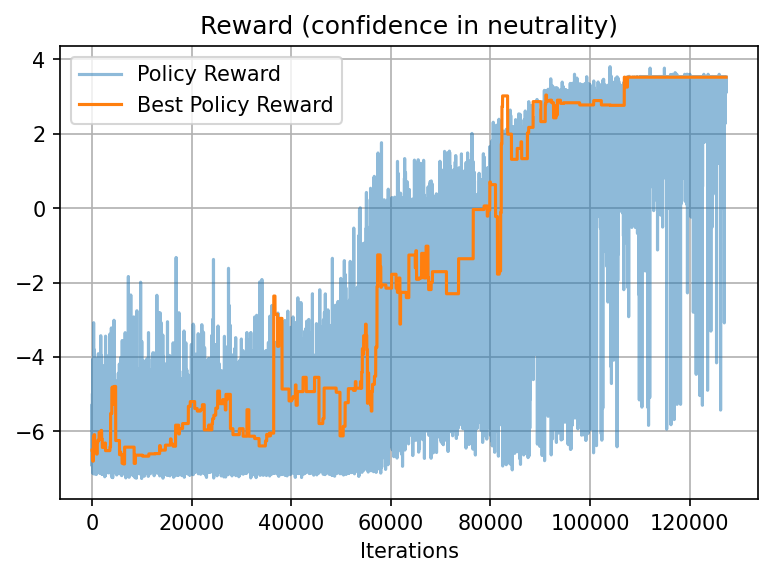

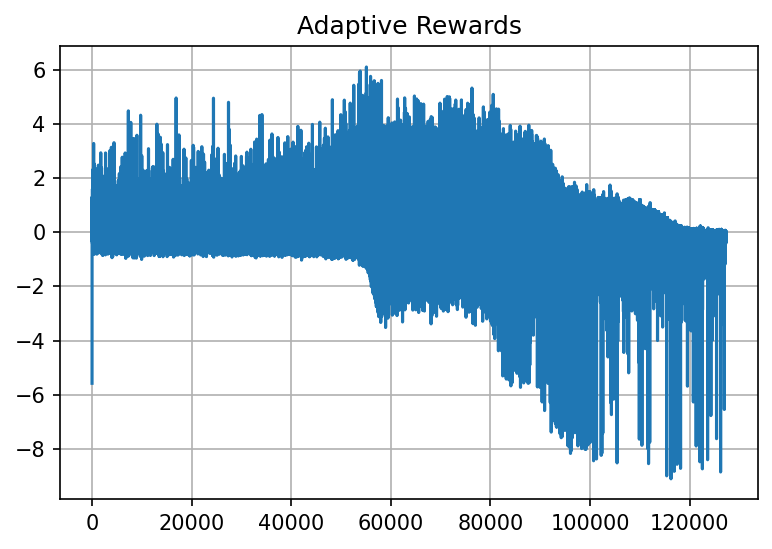

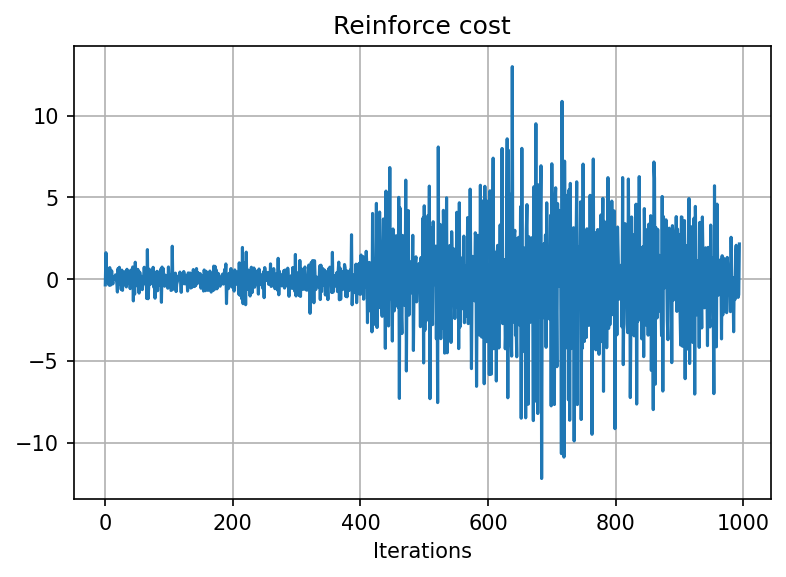

iters: 127345   inj_len: 7
current:    ・950—90ageᅵvii
max:        ・950—90ageᅵvii
best:       ・950—90ageᅵvii


In [22]:
plt.figure(dpi=150)
plt.plot(-np.array(scores_adv), alpha=0.5)
plt.plot(-np.array(scores_adv_max))
plt.xlabel("Iterations")
plt.grid()
plt.legend(["Policy Reward", "Best Policy Reward"])
plt.title("Reward (confidence in neutrality)")
plt.show()

plt.figure(dpi=150)
plt.plot(rewards)
plt.grid()
plt.title("Adaptive Rewards")
plt.show()

plt.figure(dpi=150)
plt.plot(losses_actor)
plt.xlabel("Iterations")
plt.grid()
plt.title("Reinforce cost")
plt.show()


print(f"iters: {iters}   inj_len: {inj_len}")
print("current:   ",tokenizer.decode(injection_translated))
print("max:       ",tokenizer.decode(injection_translated_max))
print("best:      ",tokenizer.decode(inj_best))